In [1]:
#%matplotlib plot
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import logging
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from moopt import nise, monise, nc, pgen, rennen, xnise, random_weights, esse, esse_enum

logging.disable(logging.NOTSET)
logger = logging.getLogger()
logger.setLevel(level=logging.INFO)

In [3]:
def run(d, wscalar_, sscalar_, bscalar_, algorithm='monise'):    
    if algorithm=='monise':
        moo_ = monise(weightedScalar=wscalar_, singleScalar=sscalar_,
                      nodeTimeLimit=2,
                      targetSize=solsize, targetGap=0, nodeGap=0.01, norm=True)
    if algorithm=='nise':
        moo_ = nise(weightedScalar=wscalar_, singleScalar=sscalar_,
                    targetSize=solsize, norm=True, objective='hp')
    elif algorithm=='random':
        moo_ = random_weights(weightedScalar=wscalar_, singleScalar=sscalar_,
                              targetSize=solsize)
    elif algorithm=='pgen':
        moo_ = pgen(weightedScalar=wscalar_, singleScalar=sscalar_,
                targetSize=solsize, norm=True)
    elif algorithm=='xnise':
        moo_ = xnise(weightedScalar=wscalar_, singleScalar=sscalar_,
                 targetSize=solsize, norm=True)
    elif algorithm=='rennen':
        moo_ = rennen(weightedScalar=wscalar_, singleScalar=sscalar_,
                      targetSize=solsize, norm=True)
    elif algorithm=='esse':
        moo_ = esse(boxScalar=bscalar_, singleScalar=sscalar_, enum=False,
                      targetSize=solsize)
    elif algorithm=='esse_enum':
        moo_ = esse_enum(boxScalar=bscalar_, singleScalar=sscalar_,
                      targetSize=solsize)
    elif algorithm=='esse_enum2':
        moo_ = esse(boxScalar=bscalar_, singleScalar=sscalar_, enum=True,
                      targetSize=solsize)
    
    moo_.optimize()
    objs = np.array([s.objs for s in moo_.solutionsList])
    
    return objs

## Defining the problem

### $\min w^\top(x-d)^2\\s.a. \sum_{i=1}^m x_i = 1\\  x_i\geq0\ \forall i \in \{1,\ldots,m\}$

In [4]:
import scipy.optimize as opt
from moopt.scalarization_interface import scalar_interface, single_interface, w_interface, box_interface

class xsquared(w_interface, single_interface, scalar_interface):
    def __init__(self, d, s):
        self.__M = d.size
        self.d = d
        self.s = s
        self.bounds = [(0, np.random.rand()+1*i+1) for i in range(self.M)]

    @property
    def M(self):
        return self.__M

    @property
    def feasible(self):
        return True

    @property
    def optimum(self):
        return True

    @property
    def objs(self):
        return self.__objs

    @property
    def x(self):
        return self.__x

    @property
    def w(self):
        return self.__w

    def optimize(self, w, u=None):
        """Calculates the a multiobjective scalarization"""
        if type(w)==int:
            self.__w = np.zeros(self.M)
            self.__w[w] = 1
        elif type(w)==np.ndarray and w.ndim==1 and w.size==self.M:
            self.__w = w
        else:
            raise('w is in the wrong format')


        constraints = [{'type': 'eq', 'fun': lambda x: sum(x)-1, 'jac': lambda x: np.ones(self.M)}]

        def fg(i):
            m = np.zeros(self.M)
            m[i] = 1
            return lambda x: u[i]-(x[i]-self.d[i])**2, lambda x: -m*(x-self.d)

        if not u is None:
            for i in range(self.M):
                fc, gc = fg(i)
                constraints+=[{'type': 'ineq', 'fun': fc, 'jac': gc}]

        f = lambda x: self.__w@(self.s*x-self.s*self.d)**2
        grad = lambda x: self.__w*(self.s*x-self.s*self.d)

        out = opt.minimize(f, np.ones(self.M)/self.M, jac=grad, bounds=self.bounds,
                           constraints=constraints)

        self.__x = out.x
        self.__objs = (self.s*self.x-self.s*self.d)**2
        
        
class xsquared_ps(xsquared, box_interface):
    @property
    def objs(self):
        return self.__objs
    
    @property
    def u(self):
        return self.__u

    @property
    def l(self):
        return self.__l

    @property
    def c(self):
        return self.__c
    
    @property
    def alpha(self):
        return self.__alpha
    
    def optimize(self, l, u, solutionsList=None):
        objs = lambda x: (self.s*x[:-1]-self.s*self.d)**2
        f = lambda x: x[-1]
            
        constraints = [{'type': 'eq', 'fun': lambda x: sum(x[:-1])-1}]

        def fg(i):
            return lambda x: (l[i]+x[-1]*(u[i] - l[i]))-objs(x)[i]

        for i in range(self.M):
            fc = fg(i)
            constraints+=[{'type': 'ineq', 'fun': fc}]
        
        x0 = np.ones(self.M+1)/self.M
        #print(objs(x0))
        #print(f(x0))
        #for c in constraints:
        #    print('a')
        #    print(c['fun'](x0))
        out = opt.minimize(f, x0, bounds=self.bounds+[(0, 1)],
                           constraints=constraints)

        self.__x = out.x[:-1]
        self.__objs = objs(out.x)
        
        self.__alpha = out.x[-1]
        
        #print(self.alpha)
        
        self.__u = u
        self.__l = l
        self.__c = self.l+self.alpha*(self.u-self.l)
        
        #print(self.u)
        #print(self.l)
        #print(self.c)

The class xsquared implement the defined problem following the rules imposed by the interfaces in moopt/scalarization_interfaces.py.

## Example of the problem with two dimensions

In [21]:
m = 2
#d = np.ones(M)
d = 10*np.random.rand(m)+0.001
s = np.array([np.random.rand()+2*i for i in range(m)])
d = d/d.max()

wscalar_ = sscalar_ = xsquared(d, s)
bscalar_ = xsquared_ps(d, s)

solsize = 15
methods = ['esse_enum', 'esse', 'nise', 'random']

objs2 = {}
for mth in methods:
    print(mth)
    objs2[mth] = run(d, wscalar_, sscalar_, bscalar_, algorithm=mth)

esse_enum
1.0
0.18749999999760308
0.187499999997603
0.041937367688526975
0.04193736768852696
0.041937367687716554
0.04193736768771655
0.010358720735811934
0.010358720735811925
0.010358720710756731
0.010358720710756723
0.00965718868387431
0.009657188683874307
esse
1.0
0.18749999999760308
0.187499999997603
0.04193736768852696
0.041937367688526975
0.04193736768771655
0.041937367687716554
0.010358720735811934
0.010358720735811925
0.010358720710756723
0.010358720710756731
0.009657188683874307
0.00965718868387431
nise
Finding 0th individual minima
Finding 1th individual minima
3th solution - importance: 0.29560428711048414
4th solution - importance: 0.16065380296405726
5th solution - importance: 0.045831141409951065
6th solution - importance: 0.029487187616377683
7th solution - importance: 0.013197910949946899
8th solution - importance: 0.008577849381775866
9th solution - importance: 0.005622412564970085
10th solution - importance: 0.0025180883035538677
11th solution - importance: 0.00085893

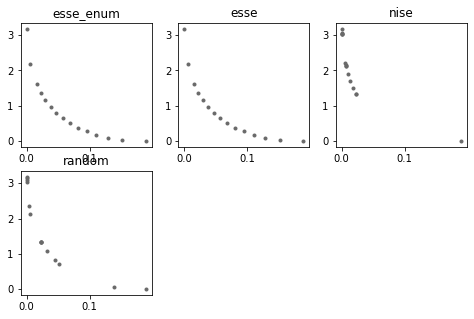

In [22]:
idx = 1
fig = plt.figure(figsize=(8,5))

for mth in methods:
    ax = fig.add_subplot(2,3, idx)
    ax.scatter(objs2[mth][:,0], objs2[mth][:,1], c='dimgrey', marker='.')
    
    plt.title(mth)
    #plt.axis('equal')
    
    idx+=1

#plt.tight_layout()
plt.show()

In [7]:
raise('error')

TypeError: exceptions must derive from BaseException

## Example of the problem with three dimensions

In [ ]:
m = 3
#d = np.ones(M)
#d = np.random.rand(m)+0.001
d = [for i in range(]
d = d/d.max()

wscalar_ = sscalar_ = xsquared(d)

solsize = 150
methods = ['monise', 'random', 'pgen', 'xnise', 'rennen']

objs3 = {}
for mth in methods:
    objs3[mth] = run(d, wscalar_, sscalar_, algorithm=mth)

In [ ]:
idx = 1
fig = plt.figure(figsize=(8,15))

for mth in methods:
    ax = fig.add_subplot(5,2, 2*idx-1, projection='3d')
    ax.scatter(objs3[mth][:,0], objs3[mth][:,1], objs3[mth][:,2], c='dimgrey', marker='.')
    ax.view_init(10, -120)
    plt.title(mth)
    plt.axis('tight')

    ax = fig.add_subplot(5,2, 2*idx, projection='3d')
    ax.scatter(objs3[mth][:,0], objs3[mth][:,1], objs3[mth][:,2], c='dimgrey', marker='.')
    ax.view_init(20, -20)
    plt.title(mth)
    plt.axis('tight')
    idx+=1


plt.tight_layout()
plt.show()